https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks?competitionId=13385&sortBy=voteCount

# Load Data

In [27]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import lightgbm
import xgboost

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

def rmse_with_log(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

얍💢
1.4.2
3.3.0
0.5.0
1.0


In [28]:
data_dir ='~/aiffel/kaggle_kakr_housing/data'
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로
submission_path = join(data_dir, 'sample_submission.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
submission = pd.read_csv(submission_path)
train.shape, test.shape, submission.shape

((15035, 21), (6468, 20), (6468, 2))

In [29]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

In [30]:
def load_data():
    data_dir ='~/aiffel/kaggle_kakr_housing/data'
    # hint : os.getenv를 사용하거나 직접 경로를 작성

    train_data_path = join(data_dir, 'train.csv')
    test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로
    submission_path = join(data_dir, 'sample_submission.csv')

    train = pd.read_csv(train_data_path)
    test = pd.read_csv(test_data_path)
    submission = pd.read_csv(submission_path)
    
    return train, test, submission

# EDA

<AxesSubplot:>

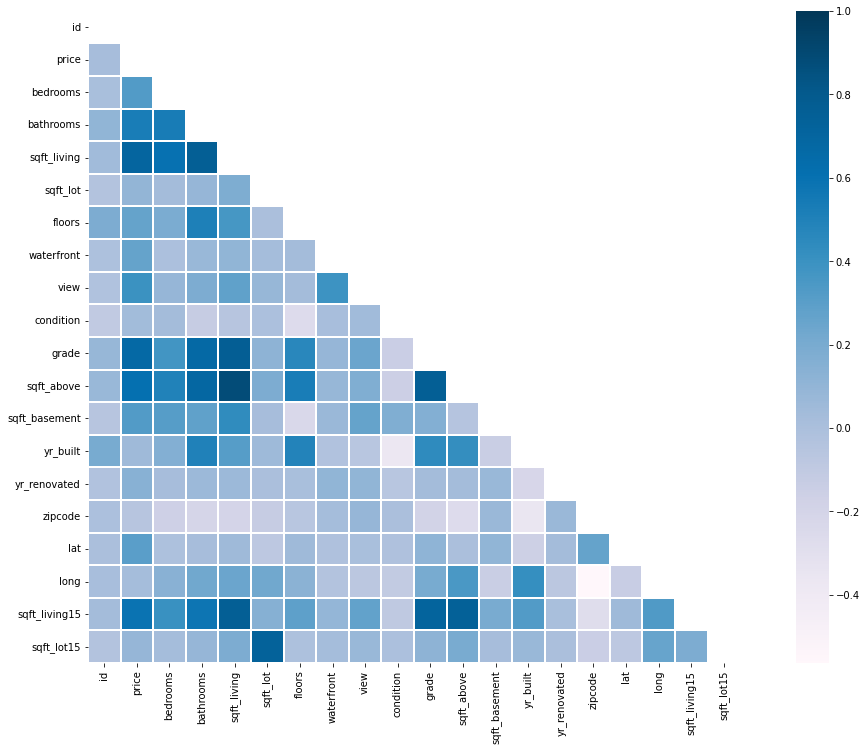

In [31]:
colormap = plt.cm.PuBu

mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 12))
sns.heatmap(train.corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", 
            annot = False, annot_kws = {"size" : 16}, mask=mask)

In [32]:
train.describe().round()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0,15035.0
mean,7517.0,540683.0,3.0,2.0,2084.0,15297.0,1.0,0.0,0.0,3.0,8.0,1794.0,290.0,1971.0,84.0,98078.0,48.0,-122.0,1993.0,12824.0
std,4340.0,371525.0,1.0,1.0,922.0,42613.0,1.0,0.0,1.0,1.0,1.0,832.0,441.0,29.0,400.0,53.0,0.0,0.0,691.0,27736.0
min,0.0,78000.0,0.0,0.0,290.0,520.0,1.0,0.0,0.0,1.0,1.0,290.0,0.0,1900.0,0.0,98001.0,47.0,-123.0,399.0,651.0
25%,3758.0,322000.0,3.0,2.0,1430.0,5028.0,1.0,0.0,0.0,3.0,7.0,1190.0,0.0,1951.0,0.0,98033.0,47.0,-122.0,1490.0,5100.0
50%,7517.0,450000.0,3.0,2.0,1910.0,7620.0,2.0,0.0,0.0,3.0,7.0,1570.0,0.0,1975.0,0.0,98065.0,48.0,-122.0,1850.0,7610.0
75%,11276.0,645000.0,4.0,2.0,2560.0,10696.0,2.0,0.0,0.0,4.0,8.0,2230.0,550.0,1997.0,0.0,98117.0,48.0,-122.0,2360.0,10076.0
max,15034.0,7700000.0,10.0,8.0,13540.0,1651359.0,4.0,1.0,4.0,5.0,13.0,9410.0,4130.0,2015.0,2015.0,98199.0,48.0,-121.0,6210.0,871200.0


In [33]:
train['isExpensive'] = train['price'] > 645000.0

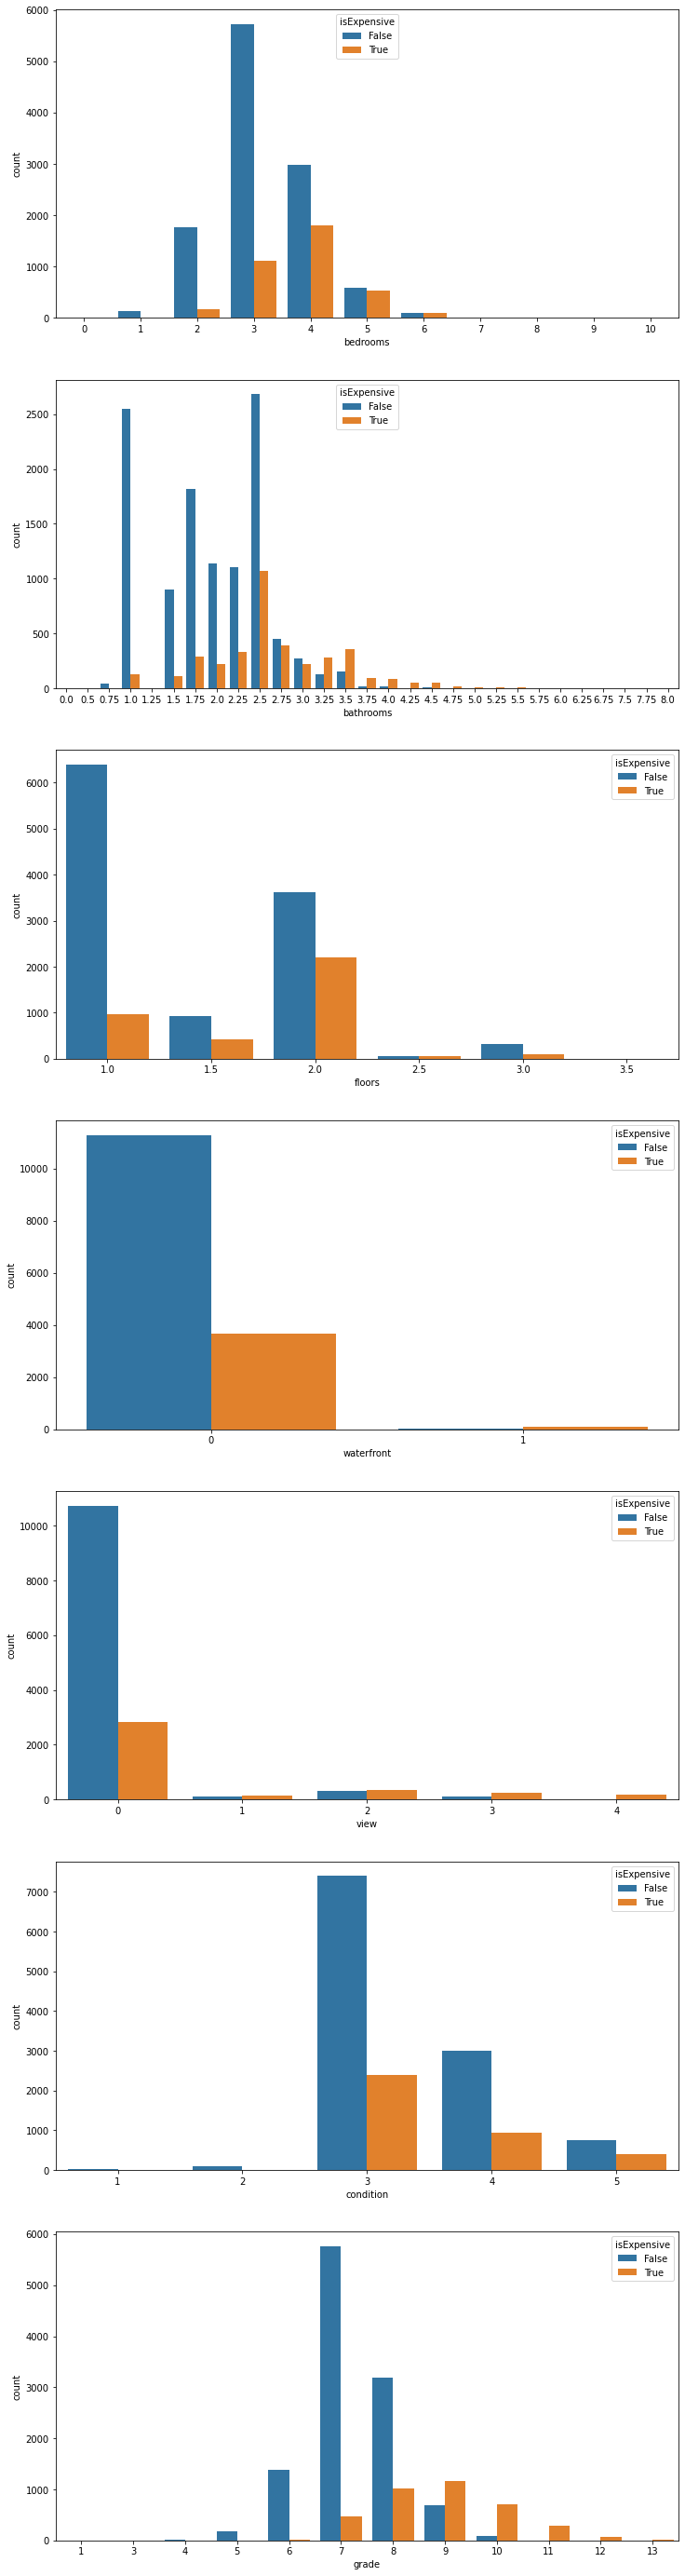

In [34]:
cat_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

fig, axes = plt.subplots(len(cat_cols), 1, figsize=(12, 50))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=train, x=col, ax=axes[i], hue='isExpensive')

- category col    

condition의 경우 1 or 2일 때는 무조건 쌌다.    
그 외의 분포에는 차이가 보이지 않음으로 1,2 여부로 바꿔줘도 좋을 것 같다.
    
grade는 확실히 차이가 많이 남.

- continuous col   
   
    -lot의 경우 상관관계도 낮고, 직관적으로도 집값에는 큰 영향이 없을 듯 하다.   

    -yr_build - yr_reno : 업데이트 주기   
    -max(yr_build) - yr_build : 노화정도   



# Feature Selection

In [35]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'isExpensive'],
      dtype='object')

In [36]:
train['zipcode'].value_counts()

98103    421
98038    420
98115    408
98052    408
98117    387
        ... 
98102     75
98010     63
98024     54
98148     44
98039     36
Name: zipcode, Length: 70, dtype: int64

In [37]:
# 의미없다고 판단되는 피처
non_ftrs = ['lat', 'long', 'zipcode', 'sqft_lot', 'sqft_lot15']

# Feature Engineering

In [38]:
# condition 1,2 여부
train['low_condition'] = train['condition'] < 3

In [39]:
# 업데이트 주기
train['Update'] = abs(train['yr_renovated'] - train['yr_built'])

In [40]:
# 노화정도
train['aging'] = max(train['yr_built']) - train['yr_built']

# Data Preprocessing

In [138]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

y = train['price']
train = train.drop(['price'], axis=1)

# 의미없다고 판단되는 피처
# non_ftrs = ['lat', 'long', 'zipcode', 'date', 'id']
# 돌려보니까 lat이랑 long은 성능향상에 도움이 됨! 그것도 많이...
non_ftrs = ['id', 'zipcode', 'date', 'sqft_lot15', 'sqft_living15']

train['date'] = train['date'].apply(lambda x : str(x[:6]))


train.drop(non_ftrs, axis=1, inplace=True)
test.drop(non_ftrs, axis=1, inplace=True)

# condition 1,2 여부
# train['low_condition'] = train['condition'] < 3
# test['low_condition'] = test['condition'] < 3
# 업데이트 주기
train['Update'] = abs(train['yr_renovated'] - train['yr_built'])
test['Update'] = abs(test['yr_renovated'] - test['yr_built'])
# 노화정도
train['aging'] = max(train['yr_built']) - train['yr_built']
test['aging'] = abs(test['yr_built'] - test['yr_built'])

# # 원핫인코딩
# cat_cols = ['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
# # category를 string으로 바꾸기
# train[cat_cols] = train[cat_cols].astype(str)
# test[cat_cols] = test[cat_cols].astype(str)

# train = pd.get_dummies(train, drop_first=True)
# test = pd.get_dummies(test, drop_first=True)

In [42]:
train.shape, test.shape, y.shape

((15035, 19), (6468, 19), (15035,))

In [145]:
def load_preprocessed_data():
    train, test, sub = load_data()

    y = train['price']
    train = train.drop(['price'], axis=1)

    # 의미없다고 판단되는 피처
    # non_ftrs = ['lat', 'long', 'zipcode', 'date', 'id']
    # 돌려보니까 lat이랑 long은 성능향상에 도움이 됨! 그것도 많이...
    non_ftrs = ['id', 'zipcode', 'date', 'sqft_lot15', 'sqft_living15']

    train['date'] = train['date'].apply(lambda x : str(x[:6]))

    train.drop(non_ftrs, axis=1, inplace=True)
    test.drop(non_ftrs, axis=1, inplace=True)
    
    skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

    for c in skew_columns:
        train[c] = np.log1p(train[c].values)
        test[c] = np.log1p(test[c].values)

    # condition 1,2 여부 -> 성능하락, 제외하기로
#     train['low_condition'] = train['condition'] < 3
#     test['low_condition'] = test['condition'] < 3
    # 업데이트 주기
    train['Update'] = abs(train['yr_renovated'] - train['yr_built'])
    test['Update'] = abs(test['yr_renovated'] - test['yr_built'])
    # 노화정도
    train['aging'] = max(train['yr_built']) - train['yr_built']
    test['aging'] = abs(test['yr_built'] - test['yr_built'])
    
    
    y_log = np.log1p(y)
    
    return train, y_log, test, sub

In [44]:
train, y, test, sub = load_preprocessed_data()
train.shape, y.shape, test.shape, sub.shape

((15035, 19), (15035,), (6468, 19), (6468, 2))

# Baseline Model

In [139]:
tr_X, ts_X, tr_y, ts_y = train_test_split(train, y.values, test_size=0.2, random_state=2023)

In [140]:
lightgbm = lgb.LGBMRegressor(random_state=2019)

lightgbm.fit(tr_X, tr_y)

pred = lightgbm.predict(ts_X)

rmse(pred, ts_y)

133513.07606763596

In [141]:
# gboost = GradientBoostingRegressor(random_state=2019) # 요 녀석도 뺴는게 좋다.
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':xgboost, 'name':'XGBoost'}, {'model':lightgbm, 'name':'LightGBM'}]

In [142]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [143]:
pred = AveragingBlending(models, tr_X, tr_y, ts_X)
rmse(pred, ts_y)

124863.0186255937

## 최종적으로 사용할 데이터, 모델 

데이터 
- drop_features : ['id', 'zipcode', 'date']
- feature_engineering : low_condition(condition 1, 2 여부) , aging(지어진 연수), Update(리모델링 된 연수)

모델
- AvgBlending model

In [146]:
train, y, test, sub = load_preprocessed_data()

In [148]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':xgboost, 'name':'XGBoost'}, {'model':lightgbm, 'name':'LightGBM'}]

tr_X, ts_X, tr_y, ts_y = train_test_split(train, y.values, test_size=0.2, random_state=2023)
pred = AveragingBlending(models, tr_X, tr_y, ts_X)
pred = np.expm1(pred)
ts_y = np.expm1(ts_y)
rmse(pred, ts_y)

114651.3770073626

# Experiment

## category 값을 원핫인코딩 할까 , 아니면 label encoding 된채로 사용할까?
- 바꾼 것 : 137374 / 안바꾼 것 : 133415
- 결론: 바꾸지 말자

In [22]:
train, test, _ = load_data()

y = train['price']
train = train.drop(['price'], axis=1)

# 의미없다고 판단되는 피처
# non_ftrs = ['lat', 'long', 'zipcode', 'date', 'id']
non_ftrs = ['id', 'zipcode', 'date']

train.drop(non_ftrs, axis=1, inplace=True)
test.drop(non_ftrs, axis=1, inplace=True)

# condition 1,2 여부
train['low_condition'] = train['condition'] < 3
test['low_condition'] = test['condition'] < 3
# 업데이트 주기
train['Update'] = abs(train['yr_renovated'] - train['yr_built'])
test['Update'] = abs(test['yr_renovated'] - test['yr_built'])
# 노화정도
train['aging'] = max(train['yr_built']) - train['yr_built']
test['aging'] = abs(test['yr_built'] - test['yr_built'])

# 원핫인코딩
cat_cols = ['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
## category를 string으로 바꾸기
train[cat_cols] = train[cat_cols].astype(str)
test[cat_cols] = test[cat_cols].astype(str)
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

tr_X, ts_X, tr_y, ts_y = train_test_split(train, y.values, test_size=0.2, random_state=2023)
lightgbm = lgb.LGBMRegressor(random_state=2019)
lightgbm.fit(tr_X, tr_y)
pred = lightgbm.predict(ts_X)
rmse(pred, ts_y)

137374.59544617627

## Average Blending > Single Model
- 단순히 모델의 결과를 평균한 결과가 단일모델보다 더 좋다   
- 127625 > 133415

##  log 함수로 정규분포로 근사시켜줘야하나?
- 바꾼 것 : 117164 / 안바꾼 것 : 133415
- 바꾼게 더 좋다

In [164]:
train, _, _ = load_data()

y = train['price']
train = train.drop(['price'], axis=1)

# 의미없다고 판단되는 피처
# non_ftrs = ['lat', 'long', 'zipcode', 'date', 'id']
non_ftrs = ['id', 'zipcode', 'date']

train.drop(non_ftrs, axis=1, inplace=True)

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

y_log = np.log1p(y)

tr_X, ts_X, tr_y, ts_y = train_test_split(train, y_log, test_size=0.2, random_state=2017)

xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [
    {'model':xgboost, 'name':'XGBoost'}, 
    {'model':lightgbm, 'name':'LightGBM'}
]

pred = AveragingBlending(models, tr_X, tr_y, ts_X)
pred = np.expm1(pred)
ts_y = np.expm1(ts_y)
rmse(pred, ts_y)

107373.25247172016

## 통계값(min, max, mean)을 추가하면 성능이 증가할까?
- 바꾼 것 : 119878 / 안바꾼 것 : 117164
- 바꾸지 말자

## 기타 피처 추가해보기
- 바꾼 것 : 114166 / 안바꾼 것 : 112773

In [162]:
train, _, _ = load_data()

y = train['price']
train = train.drop(['price'], axis=1)

# 의미없다고 판단되는 피처
# non_ftrs = ['lat', 'long', 'zipcode', 'date', 'id']
non_ftrs = ['id', 'zipcode', 'date', 'sqft_lot15', 'sqft_living15']

train.drop(non_ftrs, axis=1, inplace=True)

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
for c in skew_columns:
    train[c] = np.log1p(train[c].values)

# 재개발된 연도가 없으면 지은 연도로 바꿔주기 
train['yr_renovated'] = train['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
train['yr_renovated'] = train['yr_renovated'].fillna(train['yr_built'])

# 방의 개수
train['total_rooms'] = train['bedrooms'] + train['bathrooms']
# 방의 비율 
train['sqft_ratio'] = train['sqft_living'] / train['sqft_lot']
# 방의 전체 사이즈
train['sqft_total_size'] = train['sqft_living'] + train['sqft_lot'] + train['sqft_above'] + train['sqft_basement']
# 재개발이 되었는지 여부
train['is_renovated'] = train['yr_renovated'] - train['yr_built']
train['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
# 생산된 후 연수 
train['aging'] = max(train['yr_built']) - train['yr_built']

y_log = np.log1p(y)

tr_X, ts_X, tr_y, ts_y = train_test_split(train, y_log, test_size=0.2, random_state=2017)

xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [
    {'model':xgboost, 'name':'XGBoost'}, 
    {'model':lightgbm, 'name':'LightGBM'}
]

pred = AveragingBlending(models, tr_X, tr_y, ts_X)
pred = np.expm1(pred)
ts_y = np.expm1(ts_y)
rmse(pred, ts_y)

108850.09413139313

# Tuning

https://smecsm.tistory.com/133

In [24]:
train, y, test, sub = load_preprocessed_data()

In [25]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=3, verbose=1, n_jobs=5)
    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    results = pd.DataFrame(params)
    score = grid_model.cv_results_['mean_test_score']
    results['score'] = score
    
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results = results.sort_values(by=['RMSLE'])
    
    return results

In [26]:
model = lgb.LGBMRegressor(random_state=2023)

param_grid = {
    'n_estimators': list(range(50, 100, 10)),
    'max_depth': list(range(2, 20, 2)),
    'num_leaves': list(range(5, 50, 5))
}

my_GridSearch(model, train, y, param_grid)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


KeyboardInterrupt: 

In [ ]:
model = xgb.XGBRegressor(random_state=2023)

param_grid = {
    'n_estimators': [100],
    'max_depth': list(range(3, 10, 2)),
    'min_child_weight': list(range(3, 20, 5)),
    'learning_rate': np.array(list(range(10, 20, 2))) * 0.01
}

my_GridSearch(model, train, y, param_grid)

In [ ]:
train, y, test, sub = load_preprocessed_data()
tr_X, ts_X, tr_y, ts_y = train_test_split(train, y.values, test_size=0.2, random_state=2023)

In [ ]:
# 1. 최적의 max_depth 찾기 -> 12
for i in range(5, 20):
    lgbm_param = {
    'n_estimators': 1000,
    'max_depth': i
    }
    lightgbm = lgb.LGBMRegressor(**lgbm_param)
    
    lightgbm.fit(tr_X, tr_y)
    pred = lightgbm.predict(ts_X)
    
    print(f"{i} / {rmse(np.expm1(pred), np.expm1(ts_y)):.3f}")

In [ ]:
# 2. num_leaves 튜닝
for i in range(70, 500):
    lgbm_param = {
    'n_estimators': 1000,
    'max_depth': 12,
    'num_leaves':i
    }
    lightgbm = lgb.LGBMRegressor(**lgbm_param)
    
    lightgbm.fit(tr_X, tr_y)
    pred = lightgbm.predict(ts_X)
    
    print(f"{i} / {rmse(np.expm1(pred), np.expm1(ts_y)):.3f}")

In [ ]:
xgb_param = {
    'n_estimators': 1000,
    'max_depth': 9,
    'min_child_weight': 18,
    'learning_rate': 0.1
}
xgboost = xgb.XGBRegressor(**xgb_param)

xgboost.fit(tr_X, tr_y)
pred = xgboost.predict(ts_X)

print(f"{i} / {rmse(np.expm1(pred), np.expm1(ts_y)):.3f}")

# Submission

In [ ]:
train, test, submission = load_data()

y = train['price']
train.drop(['price'], axis=1, inplace=True)

# 의미없다고 판단되는 피처
non_ftrs = ['lat', 'long', 'zipcode', 'sqft_lot', 'sqft_lot15', 'date', 'id']

train.drop(non_ftrs, axis=1, inplace=True)
test.drop(non_ftrs, axis=1, inplace=True)

# condition 1,2 여부
train['low_condition'] = train['condition'] < 3
test['low_condition'] = test['condition'] < 3
# 업데이트 주기
train['Update'] = abs(train['yr_renovated'] - train['yr_built'])
test['Update'] = abs(test['yr_renovated'] - test['yr_built'])
# 노화정도
train['aging'] = max(train['yr_built']) - train['yr_built']
test['aging'] = abs(test['yr_built'] - test['yr_built'])

## 1차 제출
- lightGBM 기본 설정으로 학습 후 제출    
- Private : 187240
- Public : 211392

In [ ]:
save_dir ='~/aiffel/kaggle_kakr_housing/data'

lightgbm = lgb.LGBMRegressor(random_state=2019)
lightgbm.fit(train, y)
pred = lightgbm.predict(test)
submission['price'] = pred
submission.to_csv(f'{save_dir}/sub_{193031}.csv', index=False)

## 2차 제출
- AvgBlending 기본 모델
- Private : 183208
- Public : 204081

In [ ]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [ ]:
save_dir ='~/aiffel/kaggle_kakr_housing/data'

pred = AveragingBlending(models, train, y, test)
submission['price'] = pred
submission.to_csv(f'{save_dir}/sub_{186029}.csv', index=False)

## 3차 제출
- AvgBlending 기본 모델 + 최종 데이터
- Private : 120266
- Public : 118173

In [ ]:
train, y, test, sub = load_preprocessed_data()

In [ ]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

pred = AveragingBlending(models, train, y, test)
pred = np.expm1(pred)

In [ ]:
pred = AveragingBlending(models, train, y, test)
pred = np.expm1(pred)

save_dir ='~/aiffel/kaggle_kakr_housing/data'

sub['price'] = pred
sub.to_csv(f'{save_dir}/sub_{117851}.csv', index=False)

## 4자 제출
- Tuning한 AvgBlending 모델 + 최종 데이터
- Private : 113548
- Public Score : 108363

In [ ]:
train, y, test, sub = load_preprocessed_data()
tr_X, ts_X, tr_y, ts_y = train_test_split(train, y.values, test_size=0.2, random_state=2023)

In [ ]:
xgb_param = {
    'n_estimators': 1000,
    'max_depth': 9,
    'min_child_weight': 18,
    'learning_rate': 0.1
}
xgboost = xgb.XGBRegressor(**xgb_param)

lgbm_param = {
    'n_estimators': 1000,
    'max_depth': 12,
    'num_leaves':165
    }
lightgbm = lgb.LGBMRegressor(**lgbm_param)

models = [{'model':xgboost, 'name':'XGBoost'}, {'model':lightgbm, 'name':'LightGBM'}]

pred = AveragingBlending(models, train, y, test)
sub['price'] = np.expm1(pred)

save_dir ='~/aiffel/kaggle_kakr_housing/data'

sub.to_csv(f'{save_dir}/sub_{112301}.csv', index=False)

## 5차 제출
- 피처 추가해봄

In [167]:
train, test, sub = load_data()

y = train['price']
train = train.drop(['price'], axis=1)


# 의미없다고 판단되는 피처
# non_ftrs = ['lat', 'long', 'zipcode', 'date', 'id']
non_ftrs = ['id', 'zipcode', 'date', 'sqft_lot15', 'sqft_living15']

train.drop(non_ftrs, axis=1, inplace=True)
test.drop(non_ftrs, axis=1, inplace=True)

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)


# 재개발된 연도가 없으면 지은 연도로 바꿔주기 
train['yr_renovated'] = train['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
train['yr_renovated'] = train['yr_renovated'].fillna(train['yr_built'])

test['yr_renovated'] = test['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
test['yr_renovated'] = test['yr_renovated'].fillna(test['yr_built'])

# 방의 개수
train['total_rooms'] = train['bedrooms'] + train['bathrooms']
test['total_rooms'] = test['bedrooms'] + test['bathrooms']

# 방의 비율 
train['sqft_ratio'] = train['sqft_living'] / train['sqft_lot']
test['sqft_ratio'] = test['sqft_living'] / test['sqft_lot']

# 방의 전체 사이즈
train['sqft_total_size'] = train['sqft_living'] + train['sqft_lot'] + train['sqft_above'] + train['sqft_basement']
test['sqft_total_size'] = test['sqft_living'] + test['sqft_lot'] + test['sqft_above'] + test['sqft_basement']

# 재개발이 되었는지 여부
train['is_renovated'] = train['yr_renovated'] - train['yr_built']
train['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
test['is_renovated'] = test['yr_renovated'] - test['yr_built']
test['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

# 생산된 후 연수 
train['aging'] = max(train['yr_built']) - train['yr_built']
test['aging'] = max(test['yr_built']) - test['yr_built']

y_log = np.log1p(y)

In [177]:
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [
    {'model':xgboost, 'name':'XGBoost'}, 
    {'model':lightgbm, 'name':'LightGBM'}
]

pred = AveragingBlending(models, train, y_log, test)
sub['price'] = np.expm1(pred)

save_dir ='~/aiffel/kaggle_kakr_housing/data'

sub.to_csv(f"{save_dir}/sub_{'add_features_baisc_model'}.csv", index=False)

In [179]:
xgb_param = {
    'n_estimators': 1000,
    'max_depth': 9,
    'min_child_weight': 18,
    'learning_rate': 0.1
}
xgboost = xgb.XGBRegressor(**xgb_param)

lgbm_param = {
    'n_estimators': 1000,
    'max_depth': 12,
    'num_leaves':165
    }
lightgbm = lgb.LGBMRegressor(**lgbm_param)

models = [{'model':xgboost, 'name':'XGBoost'}, {'model':lightgbm, 'name':'LightGBM'}]

pred = AveragingBlending(models, train, y_log, test)
sub['price'] = np.expm1(pred)

save_dir ='~/aiffel/kaggle_kakr_housing/data'

sub.to_csv(f"{save_dir}/sub_{'add_features_tuning_model'}.csv", index=False)